<img src=https://www.udc.es/export/sites/udc/silazarillo/_galeria_imgs/03_Simbolo_logo_cor.png_2063069294.png width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

# Tema 4: Comparación de modelos

#### Ejemplo de uso de contrastes de hipótesis para la comparación de múltiples modelos

#### Importación de las librerías:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

#### Lectura de los datos del Iris:

In [2]:
Datos = pd.read_csv("./Iris.data", header=None)
X = Datos.iloc[:,:-1]       
t = Datos.iloc[:,-1].values

#### Validación cruzada de los modelos (Logistic Regression, LDA y KNN):

In [3]:
CV = 20
scoring = ['precision_macro', 'recall_macro', 'precision_micro', 'recall_micro', 'f1_macro', 'accuracy']

modelLR = LogisticRegression(penalty=None, solver = 'lbfgs', max_iter=10000, multi_class='multinomial')
scoresLR = cross_validate(modelLR, X, t, cv=CV, scoring=scoring)
print('Media del LR  : ', np.mean(scoresLR['test_accuracy']))

modelLDA = LinearDiscriminantAnalysis()
scoresLDA = cross_validate(modelLDA, X, t, cv=CV, scoring=scoring)
print('Media del LDA : ', np.mean(scoresLDA['test_accuracy']))

modelKNN = KNeighborsClassifier(n_neighbors=71) # Por ejemplo, con 71 vecinos sale diferencia significativa
scoresKNN = cross_validate(modelKNN, X, t, cv=CV, scoring=scoring)
print('Media del KNN : ', np.mean(scoresKNN['test_accuracy']))

Media del LR  :  0.9785714285714286
Media del LDA :  0.9785714285714286
Media del KNN :  0.9017857142857144


#### Se muestra un diagrama de cajas con los resultados de la validación cruzada:

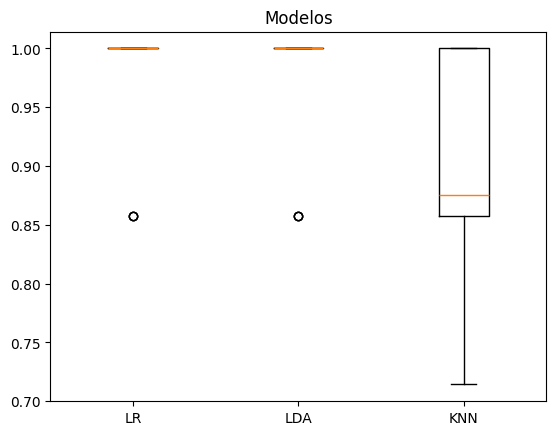

In [4]:
data = [scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy']]
fig7, ax = plt.subplots()
ax.set_title('Modelos')
ax.boxplot(data,labels=['LR','LDA','KNN']);

#### Contraste de hipótesis:

Primero se muestran los resultados obtenidos aplicando el test de [Kruskall-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) y el test de [Anova](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). Si se rechaza la hipótesis, entonces se puede afirmar que los modelos son diferentes y, posteriormente, se aplican dos test de comparación múltiple mediante el uso de la clase [MultiComparison](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html). Estos métodos comprueban si hay diferencias significativas con un p<0.05, corrigiendo el hecho de que se están haciendo múltiples comparaciones que normalmente aumentarían la probabilidad de que se identifique una diferencia significativa. Un resultado de "reject = true" significa que se ha observado una diferencia significativa:
- Método de Tukey. Se emplea para ello la función [tukeyhsd](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd.html#statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd).
- Método de Holm-Bonferroni. Se emplea para ello la función [allpairtest](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest)

In [9]:
alpha = 0.01
F_statistic, pVal = stats.kruskal(scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy'])
F_statistic2, pVal2 = stats.f_oneway(scoresLR['test_accuracy'], scoresLDA['test_accuracy'], scoresKNN['test_accuracy'])
print ('p-valor KrusW:', pVal)
print ('p-valor ANOVA:', pVal2)
if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')
    stacked_data = np.vstack((scoresLR['test_accuracy'],scoresLDA['test_accuracy'],scoresKNN['test_accuracy'])).ravel()
    stacked_model = np.vstack((np.repeat('modelLR',CV),np.repeat('modelLDA',CV),np.repeat('modelKNN',CV))).ravel()    
    MultiComp = MultiComparison(stacked_data, stacked_model)
    comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm')
    print (comp[0])    
    print(MultiComp.tukeyhsd(alpha=0.05))
else:
    print('Aceptamos la hipótesis: los modelos son iguales')

p-valor KrusW: 0.004055591777696597
p-valor ANOVA: 0.0007334945161872291
Rechazamos la hipótesis: los modelos son diferentes

Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.02, alphacBonf=0.017
 group1   group2    stat   pval  pval_corr reject
-------------------------------------------------
modelKNN modelLDA -2.9127 0.0089    0.0268   True
modelKNN  modelLR -2.9127 0.0089    0.0268   True
modelLDA  modelLR     nan    nan       nan   True
-------------------------------------------------
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
modelKNN modelLDA   0.0768 0.0025  0.0241 0.1294   True
modelKNN  modelLR   0.0768 0.0025  0.0241 0.1294   True
modelLDA  modelLR      0.0    1.0 -0.0526 0.0526  False
-------------------------------------------------------
